# Read in netcdfs, and plot results

## landmask not working here so need to retry, mabe regrid msak for rainfall data

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

# scott way of opening files

In [3]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

In [4]:
# create a list of the paths
pr_paths = [f"/g/data/w48/kb6999/20CR_PRATE_members/R_anom_Glob_PRATE{m:02d}.nc" for m in members]

In [5]:
# open all members of rainfall 
ds_pr = xr.open_mfdataset(pr_paths, combine='nested', concat_dim='member', chunks={'time': 200})
ds_pr.coords['member'] = members
ds_pr

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    PRATE    (member, time, lat, lon) float32 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

In [6]:
# combine precipitation and temperature into one dataset
reanal = xr.Dataset({'pr': ds_pr.PRATE})
# change the pr units
reanal['pr'] = reanal.pr*86400
reanal

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time, lat, lon) float64 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

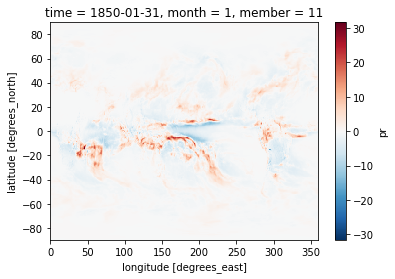

In [19]:
reanal.pr[10,0].plot()

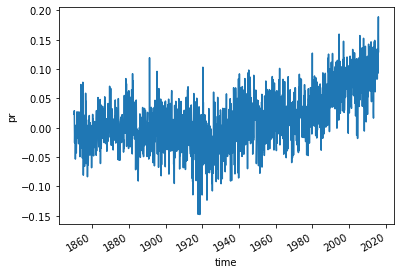

In [7]:
reanal.pr.mean(dim=['lat','lon','member']).plot()

## area weighting and landmask

In [22]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))
reanal_w

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 79, time: 1992)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
    month    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    pr       (member, time, lat, lon) float64 dask.array<chunksize=(1, 200, 256, 512), meta=np.ndarray>

In [23]:
monthly_anom_glob = reanal_w

In [32]:
!ls /g/data/ua8/C20C/v3/

about_land_masks.nc  member_daily
land.nc		     member_monthly
LAND.nc		     README_20C_Reanalysis_version_3_everymember.txt
land.sflx.nc	     spread_daily
mean_3hr	     subdaily
mean_daily	     tmp
mean_monthly	     untar.sh


In [43]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/w48/kb6999/20CR_data_netcdfs/land_pr_20CR.nc')
landmask = landfrac_ds

In [44]:
landmask

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    LAND     (lat, lon) float32 ...

## landmask not quite right!!

In [47]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(0,-90)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(90,0)) 
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-10,-50), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large

## means and percentiles

In [52]:
# take the multi-member mean
mmm_anom_glob = monthly_anom_glob.mean(dim=['member'])

In [49]:
# take lat lon mean
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [57]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.1, dim=['member'])
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.9, dim=['member'])

In [58]:
# Take the multi-member mean for each region
mmm_mon_Glob = llm_Glob.mean(dim='member')
mmm_mon_NH = llm_NH.mean(dim='member')
mmm_mon_SH = llm_SH.mean(dim='member')
mmm_mon_Aus = llm_Aus.mean(dim='member')
mmm_mon_EA = llm_EA.mean(dim='member')

## Write to netcdf

In [53]:
path = '/g/data/w48/kb6999/20CR_PRATE_data_for_plots/'

In [54]:
with dask.diagnostics.ProgressBar():
    mmm_anom_glob.to_netcdf(f'{path}mmm_anom_glob.nc')

[########################################] | 100% Completed |  4min 42.4s


In [59]:
with dask.diagnostics.ProgressBar():
#     mmm_mon_Glob.to_netcdf(f'{path}mmm_mon_pr_Glob.nc')
    mmm_mon_NH.to_netcdf(f'{path}mmm_mon_pr_NH.nc')
    mmm_mon_SH.to_netcdf(f'{path}mmm_mon_pr_SH.nc')
    mmm_mon_Aus.to_netcdf(f'{path}mmm_mon_pr_Aus.nc')
    mmm_mon_EA.to_netcdf(f'{path}mmm_mon_pr_EA.nc')

[########################################] | 100% Completed |  3min 43.9s
[########################################] | 100% Completed |  3min 36.9s
[########################################] | 100% Completed |  3min 31.5s
[########################################] | 100% Completed |  3min 17.1s


In [60]:
with dask.diagnostics.ProgressBar():
    llm_Glob.to_netcdf(f'{path}llm_pr_Glob.nc')
    llm_SH.to_netcdf(f'{path}llm_pr_SH.nc')
    llm_NH.to_netcdf(f'{path}llm_pr_NH.nc')
    llm_Aus.to_netcdf(f'{path}llm_pr_Aus.nc')
    llm_EA.to_netcdf(f'{path}llm_pr_EA.nc')

[########################################] | 100% Completed |  3min 22.3s
[########################################] | 100% Completed |  3min 17.4s
[########################################] | 100% Completed |  3min 20.1s
[########################################] | 100% Completed |  3min  6.5s
[########################################] | 100% Completed |  3min  3.3s


In [61]:
with dask.diagnostics.ProgressBar():
    p10_mon_Glob.to_netcdf(f'{path}p10_mon_pr_Glob.nc')
    p10_mon_NH.to_netcdf(f'{path}p10_mon_pr_NH.nc')
    p10_mon_SH.to_netcdf(f'{path}p10_mon_pr_SH.nc')
    p10_mon_Aus.to_netcdf(f'{path}p10_mon_pr_Aus.nc')
    p10_mon_EA.to_netcdf(f'{path}p10_mon_pr_EA.nc')

[########################################] | 100% Completed |  2min 49.4s
[########################################] | 100% Completed |  2min 48.0s
[########################################] | 100% Completed |  2min 35.3s
[########################################] | 100% Completed |  2min 47.5s
[########################################] | 100% Completed |  2min 34.4s


In [62]:
with dask.diagnostics.ProgressBar():
    p90_mon_Glob.to_netcdf(f'{path}p90_mon_pr_Glob.nc')
    p90_mon_NH.to_netcdf(f'{path}p90_mon_pr_NH.nc')
    p90_mon_SH.to_netcdf(f'{path}p90_mon_pr_SH.nc')
    p90_mon_Aus.to_netcdf(f'{path}p90_mon_pr_Aus.nc')
    p90_mon_EA.to_netcdf(f'{path}p90_mon_pr_EA.nc')

[########################################] | 100% Completed |  2min 39.6s
[########################################] | 100% Completed |  2min 49.4s
[########################################] | 100% Completed |  2min 37.5s
[########################################] | 100% Completed |  2min 30.5s
[########################################] | 100% Completed |  2min 27.5s
